In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score, confusion_matrix, matthews_corrcoef, roc_curve, auc, precision_recall_curve
from scipy.stats import gmean
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import make_scorer
from sklearn.preprocessing import StandardScaler

## Loading, Scaling and Spltting the data 

In [3]:
# loading the dataset
df = pd.read_csv(r"C:\Users\Sana\OneDrive\Desktop\creditcard.csv")

Since the entire dataset was PCA encoded and "Time" and "Amount" columns were left as it is, after loading the dataset, we scale only the "Time" and "Amount" columns in our dataset using StandardScaler() to maintain consistency.

In [4]:
scaler = StandardScaler()
df[['Time','Amount']] = scaler.fit_transform(df[['Time', 'Amount']])

In [5]:
# Splitting the data into training, validation and testing sets in 60-20-20 ratio repectively 
X = df.drop('Class', axis=1)
y = df['Class']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, stratify = y, test_size = 0.4, random_state = 42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size = 0.5, random_state = 42)

In [6]:
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((170884, 30), (56961, 30), (56962, 30), (170884,), (56961,), (56962,))

## Evalution Metrics

We define a custom function for geometric mean score since it is not directly available.

In [7]:
def gmean_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel () #ravel() returns a 1D array of the inpu elements
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    return gmean([sensitivity, specificity])

In [8]:
# Creating a list for our scoring metrics
scoring_metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'average_precision', 'mcc', 'g_mean']

# Creating a custom scoring function for mcc and gmean
mcc_scorer = make_scorer(matthews_corrcoef)
gmean_scorer = make_scorer(gmean_score)

# Creating a scoring dictionary 
scoring = {
    'accuracy' : 'accuracy',
    'precision' : 'precision',
    'recall' : 'recall',
    'f1' : 'f1',
    'roc_auc' : 'roc_auc',
    'average_precision' : 'average_precision',
    'mcc' : mcc_scorer,
    'gmean' : gmean_scorer
}

## XGBoost Model

In [9]:
# Initialising XGBoost model with XGBClassifier 
model = XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

We perform hyperparameter tuning using GridSearchCV. Grid search performs an exhaustive search throughout the specified search space, using different combinations of all the parameters and returns the best parameters for the model. 

We also calculate class weight in order to incorporate cost-sensitive learning. this is done by calculating the ratio of:

Total number of negative class in training set / Total number of positive class in training set

For cross validation, we perform Stratified - K fold cross validation because we have a highly unbalanced dataset and we need to maintain the same proportion of positive class in each fold.


In [10]:
# Class weights
positive_class_weight = int((y_train == 0).sum() / (y_train == 1).sum())

# Initialising parameter grid  
params_grid = {
    'n_estimators' : [800, 900, 1000, 1100,1500],
    'max_depth' : [6,9,12],
    'learning_rate' : [0.001],
    'scale_pos_weight' : [positive_class_weight]
}

# Stratified K-fold Cross Validation
cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)

In [11]:
# Performing Grid Search CV
grid_search = GridSearchCV(model, params_grid, scoring = scoring, cv = cv, verbose = 0, refit = 'precision')

In [12]:
grid_search_fit = grid_search.fit(X_train, y_train)
grid_search_fit

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     callbacks=None, colsample_bylevel=1,
                                     colsample_bynode=1, colsample_bytree=1,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=0, gpu_id=-1,
                                     grow_policy='depthwise',
                                     importance_type=None,
                                     interaction_cons...
                                     random_state=0, reg_alpha=0, reg_lambda=1, ...),
             param_grid={'learning_rate': [0.001], 'max_depth': [12],
                         'n_estimators': [1500], 'scale_pos_weight': [578]},
             refit='precision',
             scoring={'accuracy': 'accuracy',
          

In [13]:
# Best hyperparameters 
best_params = grid_search_fit.best_params_
print("Best parameters found: ",best_params) 

Best parameters found:  {'learning_rate': 0.001, 'max_depth': 12, 'n_estimators': 1500, 'scale_pos_weight': 578}


We train our XGB model with the best paramters found through hyperparameter tuning 

In [14]:
# Training the best model 
best_model = XGBClassifier(**best_params)
best_model.fit(X_train, y_train, early_stopping_rounds = 10, eval_metric = 'logloss', eval_set = [(X_val, y_val)])

C:\Users\Sana\anaconda3\envs\rstudio\lib\site-packages\xgboost\sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,
C:\Users\Sana\anaconda3\envs\rstudio\lib\site-packages\xgboost\sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,


[0]	validation_0-logloss:0.69215
[1]	validation_0-logloss:0.69116
[2]	validation_0-logloss:0.69017
[3]	validation_0-logloss:0.68919
[4]	validation_0-logloss:0.68820
[5]	validation_0-logloss:0.68722
[6]	validation_0-logloss:0.68624
[7]	validation_0-logloss:0.68526
[8]	validation_0-logloss:0.68428
[9]	validation_0-logloss:0.68330
[10]	validation_0-logloss:0.68233
[11]	validation_0-logloss:0.68136
[12]	validation_0-logloss:0.68039
[13]	validation_0-logloss:0.67942
[14]	validation_0-logloss:0.67845
[15]	validation_0-logloss:0.67749
[16]	validation_0-logloss:0.67653
[17]	validation_0-logloss:0.67557
[18]	validation_0-logloss:0.67461
[19]	validation_0-logloss:0.67365
[20]	validation_0-logloss:0.67270
[21]	validation_0-logloss:0.67174
[22]	validation_0-logloss:0.67079
[23]	validation_0-logloss:0.66984
[24]	validation_0-logloss:0.66890
[25]	validation_0-logloss:0.66795
[26]	validation_0-logloss:0.66701
[27]	validation_0-logloss:0.66607
[28]	validation_0-logloss:0.66513
[29]	validation_0-loglos

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.001, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=12, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=1500,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

# Validation Set Results

In [16]:
# Predicting on validation set 
y_pred_val = best_model.predict(X_val)

# Calculating evaluation Metrics on Validation Set
val_accuracy = accuracy_score(y_val, y_pred_val)
val_precision = precision_score(y_val, y_pred_val)
val_recall = recall_score(y_val, y_pred_val)
val_f1 = f1_score(y_val, y_pred_val)
val_roc_auc = roc_auc_score(y_val, y_pred_val)
val_pr_auc = average_precision_score(y_val, y_pred_val)
val_mcc = matthews_corrcoef(y_val, y_pred_val)
val_gmean = gmean_score(y_val, y_pred_val)
val_cm = confusion_matrix(y_val, y_pred_val)

In [17]:
# Validation Set Results

print("Validation Set Results: ")
print(f"Accuracy: {val_accuracy}")
print(f"Precision: {val_precision}")
print(f"Recall: {val_recall}")
print(f"F1: {val_f1}")
print(f"ROC-AUC: {val_roc_auc}")
print(f"PR-AUC: {val_pr_auc}")
print(f"Matthew Correlation Coefficient: {val_mcc}")
print(f"G-Mean: {val_gmean}")
print(f"Confusion Matrix: {val_cm}")

Validation Set Results: 
Accuracy: 0.9984375274310493
Precision: 0.5751633986928104
Recall: 0.7857142857142857
F1: 0.6641509433962263
ROC-AUC: 0.8922854529417529
PR-AUC: 0.4523354398903923
Matthew Correlation Coefficient: 0.6715094985141998
G-Mean: 0.8858983665450819
Confusion Matrix: [[56784    65]
 [   24    88]]


## Test Set Results 

In [18]:
# Prdicting on Test Set
y_pred_test = best_model.predict(X_test)
y_prob_pred_test = best_model.predict_proba(X_test)[:, 1]

# Calculating evaluation metrics on test set
test_accuracy = accuracy_score(y_test, y_pred_test)
test_precision = precision_score(y_test, y_pred_test)
test_recall = recall_score(y_test, y_pred_test)
test_f1 = f1_score(y_test, y_pred_test)
test_roc_auc = roc_auc_score(y_test, y_pred_test)
test_pr_auc = average_precision_score(y_test, y_pred_test)
test_mcc = matthews_corrcoef(y_test, y_pred_test)
test_gmean = gmean_score(y_test, y_pred_test)
test_cm = confusion_matrix(y_test, y_pred_test)

In [19]:
# Test Set Results

print("Test Set Results: ")
print(f"Accuracy: {test_accuracy}")
print(f"Precision: {test_precision}")
print(f"Recall: {test_recall}")
print(f"F1: {test_f1}")
print(f"ROC-AUC: {test_roc_auc}")
print(f"PR-AUC: {test_pr_auc}")
print(f"Matthew Correlation Coefficient: {test_mcc}")
print(f"G-Mean: {test_gmean}")
print(f"Confusion Matrix: {test_cm}")

Test Set Results: 
Accuracy: 0.9986833327481479
Precision: 0.5396825396825397
Recall: 0.8
F1: 0.6445497630331753
ROC-AUC: 0.899490127819681
PR-AUC: 0.43204447632311826
Matthew Correlation Coefficient: 0.6564729343783187
G-Mean: 0.8939710311366301
Confusion Matrix: [[56819    58]
 [   17    68]]


In [20]:
y_test.value_counts()

0    56877
1       85
Name: Class, dtype: int64

## ROC - AUC

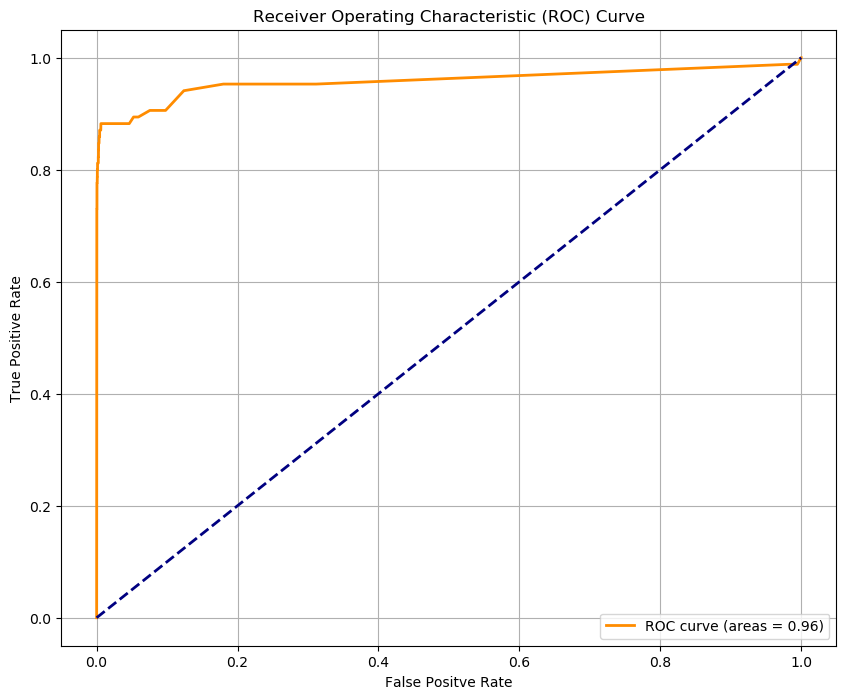

In [21]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob_pred_test)
roc_auc = auc(fpr, tpr)

plt.figure(figsize = (10,8))
plt.plot(fpr, tpr, color = 'darkorange', lw = 2, label = 'ROC curve (areas = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color = 'navy', lw = 2, linestyle = '--')
plt.xlabel('False Positve Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc = 'lower right')
plt.grid(True)
plt.show()

## PR - AUC

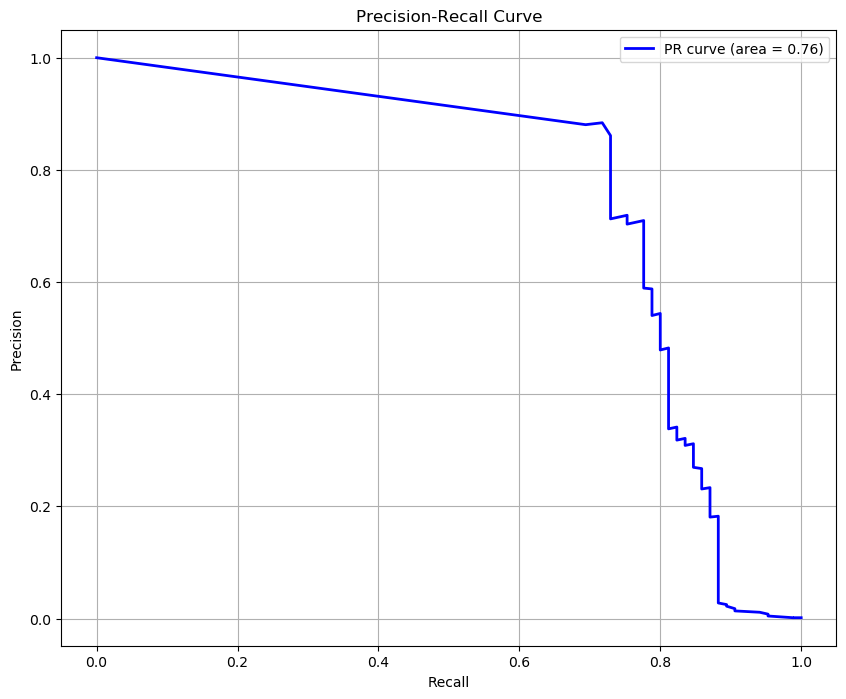

In [22]:
precision, recall, _ = precision_recall_curve(y_test, y_prob_pred_test)
pr_auc = auc(recall, precision)

plt.figure(figsize = (10, 8))
plt.plot(recall, precision, color = 'blue', lw = 2, label = 'PR curve (area = %0.2f)' % pr_auc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc = 'upper right')
plt.grid(True)
plt.show()

## Confusion Matrix

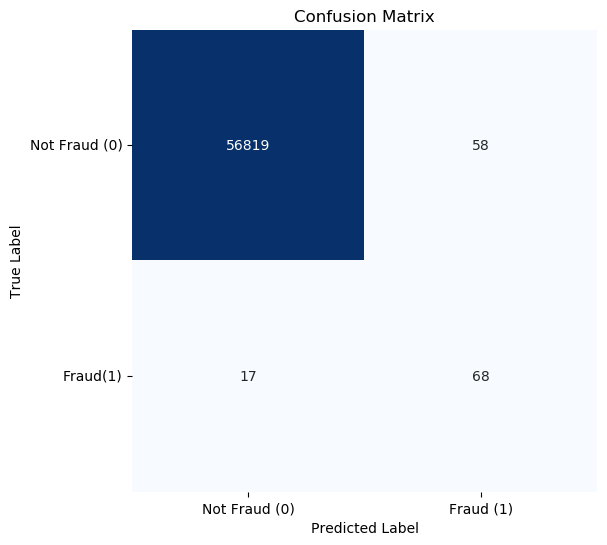

In [24]:
plt.figure(figsize = (6, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_test), annot = True, fmt = 'd', cmap = 'Blues', cbar = False, xticklabels = ['Not Fraud (0)', 'Fraud (1)'], yticklabels = ['Not Fraud (0)', 'Fraud(1)'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.yticks(rotation = 360)
plt.show()